# Fase #2 - Detección de Malware de Android
* Pablo Alejandro Méndez #19195
* Diana Zaray Corado #191025
* Orlando Osberto Cabrera #19943
* José Javier Hurtarte #19707

In [2]:
# library imports
import pandas as pd
import time
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from tensorflow.keras import models, layers, callbacks, optimizers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Análisis Exploratorio

[//]: # (La idea principal al desarrollar un modelo que permita la detección de malware en Android es poder utilizar un modelo que no solo sea capaz de identificar *malware* mediante los permisos que solicita una aplicación sino también mediante las llamadas a API´s que están realizan. Para ello se estarán utilizando dos conjuntos de datos provistos en *Kaggle* los cuales se describen a continuación.)

Se desarrollará un modelo capaz de detectar *malware* en un dispositivo Android. Esta detección estará basada en los permisos que solicita una aplicación y las llamadas API que utiliza. Para esto se utilizarán los siguientes dos conjuntos de datos previstos por *Kaggle*.

### Conjunto de datos de Permisos 

In [3]:
permission_data = pd.read_csv('/data/notebook_files/Permission Dataset.csv')
permission_data.head()

,permission.GetuiService.com.glodon.ynjtapp,permission.COLLECT_METRICS,permission.sec.MDM_PHONE_RESTRICTION,permission.MEDIA_MOUNTED,permission.USAGE_ACCESS_SETTINGS,permission.VOIP_BROADCAST_VOIP_INTENTS,permission.GetuiService.com.huamaitel.client.yun,permission.CLIENT,permission.GetuiService.pailiefive.main,permission.RESTART_PxCKAGES,...,permission.GetuiService.me.chunyu.ChunyuDoctor,permission.A4S_SEND,permission.GetuiService.com.melot.game,permission.CONTACT_SETTINGS,permission.ZALO_SERVICE,permission.GetuiService.com.hooray.snm,permission.READ_USAGESTATS,permission.USE_IFAA_MANAGER,permission.READ_MEDIA_STORAGE,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


El primer conjunto de datos a contiene **11,975** observaciones y **1,492** *features*. En este caso, los *features* representan a los permisos que solicita una aplicación para ser instalada. A su vez, se puede observar que estos datos ya se encuentran vectorizados, es decir, ya existe una representación numéricas de los permisos solicitados por una aplicación, por lo que no será necesario pre-procesarlos. 

In [4]:
permission_data['isMalware'] = permission_data['class'].apply(lambda x: not x)
permission_data = permission_data.drop(['class'], axis=1)
print(f"{permission_data['isMalware'].value_counts()}")
px.histogram(permission_data, x='isMalware',
             title='Figura 1. Representación gráfica de la cantidad de tipos de aplicaciones <br />benignas y malware en Permissions Dataset')

False    6000
True     5975
Name: isMalware, dtype: int64


### Conjunto de Llamadas a API's

In [5]:
# Indica si un feature es un permiso o llamada a API
categories = pd.read_csv('/data/workspace_files/Proyecto1/AMDML2.csv')
categories

,transact,API call signature
0,onServiceConnected,API call signature
1,bindService,API call signature
2,attachInterface,API call signature
3,ServiceConnection,API call signature
4,android.os.Binder,API call signature
...,...,...
210,ACCESS_FINE_LOCATION,Manifest Permission
211,SET_WALLPAPER_HINTS,Manifest Permission
212,SET_PREFERRED_APPLICATIONS,Manifest Permission
213,WRITE_SECURE_SETTINGS,Manifest Permission


In [6]:
api_data = pd.read_csv('/data/workspace_files/Proyecto1/AMDML.csv', low_memory=False)
api_data.head()

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,S


In [7]:
api_data['isMalware'] = api_data['class'].apply(lambda x: True if x == 'S' else False)
api_data = api_data.drop(['class'], axis=1)
print(f"{api_data['isMalware'].value_counts()}")
px.histogram(api_data, x='isMalware',
             title='Figura 1. Representación gráfica de la cantidad de tipos de aplicaciones <br />benignas y malware en API´s Dataset')

False    9476
True     5560
Name: isMalware, dtype: int64


[//]: <> (El segundo conjunto de datos a utilizar cuenta con **15,036** obsevaciones y **217** *features*. Los *features* corresponden principalmente a llamadas API´s y algunas representan permisos solicitados por una aplicación antes de su instalación. A su vez, al igual que el conjunto de datos anterior se puede observar que estos ya se encuentran vectorizados.)

El segundo conjunto de datos a utilizar cuenta con **15,036** obsevaciones y **217** *features*. A diferencia del conjunto de datos anterior, los *features* corresponden principalmente a llamadas API's; pero también incluyen a los permisos de instalación de la aplicación. Asimismo, el conjunto de datos ya se encuentra vectorizado.

## Preprocesamiento (codificación, escalamente y normalización, eliminación de features no relevantes)

Para analizar los *features* de los conjuntos de datos se utilizará *Principal Component Analysis* para agrupar el conjunto de *features* en una dimensión "manejable", con el objetivo de determinar las características relevantes. Para decidir el mejor número de reducción de componentes se utilizará un *scree plot* que funciona de manera similar a la gráfica de codo utilizada en **K-Means***

In [8]:
pca = PCA(n_components=20)
pca_data = pca.fit_transform(permission_data.drop(['isMalware'], axis=1))
pca.explained_variance_

array([2.2405182 , 0.67182515, 0.47083693, 0.30362265, 0.28418862,
 0.24289196, 0.22932905, 0.22001435, 0.20725987, 0.19461401,
 0.17611391, 0.16937435, 0.16651289, 0.14356698, 0.13614863,
 0.13300034, 0.12624251, 0.11593032, 0.11345551, 0.10719406])

In [9]:
px.line(pca.explained_variance_)

Como se observa en el gráfico anterior, el número ideal de componentes sería 2, por lo cual se hace *PCA* con 2 para analizar las características principales de los datos.

In [10]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(permission_data.drop(['isMalware'], axis=1))
permissions_pca_features = pd.DataFrame(data=pca_data)
permissions_pca_features['isMalware'] = permission_data['isMalware']
permissions_pca_features

,0,1,isMalware
0,0.406293,-1.287685,False
1,5.204345,1.525463,False
2,1.247847,-0.613707,False
3,0.816060,-0.788746,False
4,-1.330647,-0.476038,False
...,...,...,...
11970,0.532567,1.079723,True
11971,-1.546048,-0.631901,True
11972,-1.535198,0.579327,True
11973,-1.127666,0.057467,True


In [11]:
px.scatter(permissions_pca_features, x=0, y=1, color='isMalware')

[//]: <> (En el gráfico anterior se puede observar que se obtienen valores más altos para el caso de las aplicaciones benignas. Sin embargo, la mayoría de las aplicaciones en general se concentra en un mismo punto, con lo cual es difícil diferenciar mendiante este análisis aquellas características que sean más predominantes en aplicaciones de tipo *malware* o benignas) 

En el gráfico anterior se puede observar que las aplicaciones no benignas tienden a obtener valores más altos. Sin embargo, la mayoría de aplicaciones se encuentran en el mismo punto; lo que dificulta diferenciar las características predominantes de las aplicaciones *malware* y benignas.

[//]: <> (Para realizar PCA para el segundo conjunto de datos es necesario considerar que existen columnas que están en tipo de dato *string* o a su vez contienen valores de tipo null por lo que será necesario cambiar esas observaciones. En este caso se está utilizando -1 para definir aquellos datos de los cuales no se tiene información.)

Antes de realizar PCA en el segundo conjunto de datos, las observaciones que contienen cadenas de texto o *null* en algunas de sus *features*. En esos casos, se les asignará un valor de -1 para reflejar que no se tiene esa información. 

In [12]:
api_data.isnull().sum()

transact 0
onServiceConnected 0
bindService 0
attachInterface 0
ServiceConnection 0
 ..
ACCESS_FINE_LOCATION 0
SET_WALLPAPER_HINTS 0
SET_PREFERRED_APPLICATIONS 0
WRITE_SECURE_SETTINGS 0
isMalware 0
Length: 216, dtype: int64

In [13]:
api_data['TelephonyManager.getSimCountryIso'] = api_data['TelephonyManager.getSimCountryIso'].replace(to_replace='?',
                                                                                                      value=-1)
# now have to delete all the nan values
api_data['TelephonyManager.getSimCountryIso'] = api_data['TelephonyManager.getSimCountryIso'].fillna(-1)
api_data['TelephonyManager.getSimCountryIso'] = pd.to_numeric(api_data['TelephonyManager.getSimCountryIso'])

In [14]:
pca = PCA(n_components=18)
pca_data = pca.fit_transform(api_data.drop(['isMalware'], axis=1))
pca.explained_variance_

array([4.96550004, 1.31701181, 0.82879286, 0.64654354, 0.50890174,
 0.45729664, 0.39492845, 0.37142168, 0.33815086, 0.29578122,
 0.29216807, 0.27082795, 0.25426227, 0.23678982, 0.23443391,
 0.21686584, 0.2112133 , 0.18728822])

In [15]:
px.line(pca.explained_variance_)

Al igual que en la gráfica anterior se observa que el número de componentes óptimos sería 2, por lo que se aplica PCA para 2 componentes para el segundo conjunto de datos.

In [16]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(api_data.drop(['isMalware'], axis=1))
api_pca_features = pd.DataFrame(data=pca_data)
api_pca_features['isMalware'] = api_data['isMalware']
api_pca_features

,0,1,isMalware
0,-2.836505,-0.336144,True
1,-2.502625,0.234374,True
2,-2.417511,-0.397322,True
3,0.882529,2.065632,True
4,-0.941421,0.804655,True
...,...,...,...
15031,2.808139,-1.251131,False
15032,0.299657,-0.751112,False
15033,-1.830412,-0.014333,False
15034,2.563917,-0.512274,False


In [17]:
px.scatter(api_pca_features, x=0, y=1, color='isMalware')

[//]: <> (A diferencia de los resultados obtenidos con el conjunto de datos anterior, en este caso sí se puede observar que existe una diferencia entre la agrupación de características para cada uno de los tipos de aplicaciones. Se obseva que las aplicaciones benignas tienden a estar más agrupadas en la parte inferior y con un mayor rango, mientras que las maliciosas se agrupan más en la parte superior izquierda. En este caso debemos de tomar en cuenta que los datos no se encuentran balancenados y puede deberse a esto que se obtenga una mejor definición de las características de cada uno de los tipos de las aplicaciones.)

A diferencia de los resultados obtenidos con el primer conjunto de datos, se puede observar una diferencia en la agrupación de las características para las aplicaciones maliciosas y benignas.

A diferencia de los resultados obtenidos con el conjunto de datos anterior, en este caso sí se puede observar que existe una diferencia entre la agrupación de características para cada uno de los tipos de aplicaciones. Se obseva que las aplicaciones benignas tienden a estar más agrupadas en la parte inferior y con un mayor rango, mientras que las maliciosas se agrupan más en la parte superior izquierda. En este caso debemos de tomar en cuenta que los datos no se encuentran balancenados y puede deberse a esto que se obtenga una mejor definición de las características de cada uno de los tipos de las aplicaciones.

### Balanceo de data (técnicas de oversampling y undersampling)

In [18]:
benign = api_data[api_data['isMalware'] == False]
benign = benign.sample(n=6000, random_state=42)
rest = api_data[(api_data['isMalware'])]
under_api_sample = pd.concat([benign, rest])

In [19]:
print(f"{under_api_sample['isMalware'].value_counts()}")
px.histogram(under_api_sample, x='isMalware')

False    6000
True     5560
Name: isMalware, dtype: int64


Para el balanceo de datos se decidió realizar undersampling únicamente a los datos de api_sample, debido a que para este conjunto de datos se contaba con el doble de datos que no son malware que de los que si son.

En el caso del primer conjunto de datos no es necesario realizar ningún balanceo debido a que estos datos se encuentran casi perfectamente balanceados, por lo que no será necesario utilizar ninguna estrategia de balanceo.

In [20]:
under_api_sample

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,isMalware
9153,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,False
7833,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
11698,1,1,1,0,1,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,False
6527,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,False
10407,1,1,1,1,1,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5555,1,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,True
5556,0,0,0,0,0,1,0,1,1,0,...,0,0,0,1,1,1,0,0,0,True
5557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,True
5558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True


### Selección de las características finales (correlación entre las características)

Para la selección de características, debido a que se está trabajando con datos categórico y el entrenamiento depende completamente de la identificación del uso o no de un permiso o llamada a API, es por ello que para el caso en el que únicamente se tienen 217 *features* se decidió que se estarán utilizando todos los *features* provistos debido a que se busca que los modelos puedan reconocer de una mejor manera las características indistinguibles de cada uno de los tipos de aplicaciones. 

Por su parte, para el otro conjunto de datos (el que contiene información de los permisos) se estará realizando una estrategia de *feature selection* mediante el cálculo de *chi-square* para identificar aquellas características que tienen un mayor impacto en la clasificación de una aplicación de Android.

In [21]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(permission_data.drop(columns=["isMalware"], axis=1), permission_data["isMalware"])

selected_features = pd.DataFrame({
    'feature': permission_data.drop(columns=["isMalware"], axis=1).columns,
    'scores': fs.scores_
})
mean = selected_features['scores'].mean()
std = selected_features['scores'].std()
print('Valor esperado: ', mean)
print('Desviación estándar: ', std)
permission_selected_featurees = selected_features.sort_values('scores', ascending=False).iloc[
                                :int(len(selected_features) * 0.4)]

Valor esperado:  35.47790747054501
Desviación estándar:  187.6994866084523


*Chi-square* es una medida que básicamente permite obtener la correlación entre variables categóricas, ya que permite obtener la relación entre las variables independientes(*features*) y la variable dependiente (*target*). Esto permite realizar la selección de features, ya que proporciona aquellas características de las cuales la variable *target* es más dependiente, proporcionando una valor de *chi-square* más alto. 

Por lo tal, para seleccionar los mejores *features* para el conjunto de datos de permisos solicitados por una aplicación se ordenaron cada una de las características con respecto al valor de *chi-square* obtenido y se extrajo el 40% de los *features* con valores más altos, dejando así como resultado un conjunto de características de **596**.

### Separación de datos (55% para entrenamiento, 15% validación y 30% pruebas)

In [22]:
# selected permission data 
permission_predictors = permission_data[permission_selected_featurees['feature']]
permission_target = permission_data['isMalware']

In [23]:
# separate between train and test for permission_data
xpd_train, xpd_test, ypd_train, ypd_test = train_test_split(permission_predictors, permission_target, test_size=0.30,
                                                            random_state=19191919)
xpd_train, xpd_val, ypd_train, ypd_val = train_test_split(xpd_train, ypd_train, test_size=0.15, random_state=19191919)

In [24]:
xpd_train.shape

(7124, 596)

In [153]:
xuas_train, xuas_test, yuas_train, yuas_test = train_test_split(under_api_sample.drop('isMalware', axis=1),
                                                                under_api_sample['isMalware'], test_size=0.30,
                                                                random_state=19191919)
xuas_train, xuas_val, yuas_train, yuas_val = train_test_split(xuas_train, yuas_train, test_size=0.15,
                                                              random_state=19191919)

In [26]:
xuas_train

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS
9777,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,1,1,0,0,0,0
7103,0,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7698,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
5539,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9967,0,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
4833,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Implementación de Modelos


Métricas de evaluación para cada modelo (matriz de confusión, accuracy, precisión, recall, F1), se deben explicar que significan sus valores en el contexto del problema de seguridad propuesto.

Evaluación cruzada con K-10 folds para K = 10.

### 1. Detección de malware basado en permisos solicitados

In [68]:
nn_model = models.Sequential([
    layers.InputLayer(input_shape=(xpd_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, name='out_layer', activation="sigmoid")
])

nn_model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), loss='hinge', metrics=['accuracy'])

In [70]:
history_df = pd.DataFrame(history.history)
px.line()
figure = go.Figure()
figure.add_trace(go.Scatter(x=history_df.index, y=history_df['loss'], mode='lines+markers', name='loss'))
figure.add_trace(go.Scatter(x=history_df.index, y=history_df['val_loss'], mode='lines+markers', name='val_loss'))
figure.add_trace(go.Scatter(x=history_df.index, y=history_df['accuracy'], mode='lines+markers', name='accuracy'))
figure.add_trace(go.Scatter(x=history_df.index, y=history_df['val_accuracy'], mode='lines+markers', name='val_accuracy'))

In [112]:
nn_model = models.Sequential([
    layers.InputLayer(input_shape=(xpd_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1, name='out_layer', activation="sigmoid")
])

nn_model.compile(optimizer=optimizers.Adam(learning_rate=0.00012), loss='binary_crossentropy', metrics=['accuracy'])

In [113]:
toc = time.time()
history = nn_model.fit(xpd_test, ypd_test, epochs=35, validation_data=(xpd_val, ypd_val), validation_steps=10, verbose=2, batch_size=32)
tic = time.time()
print('total training time:', tic - toc, 'seconds')

Epoch 1/35
113/113 - 1s - loss: 0.6335 - accuracy: 0.6424 - val_loss: 0.5599 - val_accuracy: 0.7969 - 951ms/epoch - 8ms/step
Epoch 2/35
113/113 - 0s - loss: 0.5369 - accuracy: 0.7968 - val_loss: 0.4545 - val_accuracy: 0.8781 - 241ms/epoch - 2ms/step
Epoch 3/35
113/113 - 0s - loss: 0.4399 - accuracy: 0.8628 - val_loss: 0.3621 - val_accuracy: 0.9062 - 231ms/epoch - 2ms/step
Epoch 4/35
113/113 - 0s - loss: 0.3704 - accuracy: 0.8787 - val_loss: 0.3044 - val_accuracy: 0.9125 - 225ms/epoch - 2ms/step
Epoch 5/35
113/113 - 0s - loss: 0.3293 - accuracy: 0.8878 - val_loss: 0.2699 - val_accuracy: 0.9219 - 216ms/epoch - 2ms/step
Epoch 6/35
113/113 - 0s - loss: 0.3038 - accuracy: 0.8912 - val_loss: 0.2520 - val_accuracy: 0.9187 - 215ms/epoch - 2ms/step
Epoch 7/35
113/113 - 0s - loss: 0.2848 - accuracy: 0.8973 - val_loss: 0.2394 - val_accuracy: 0.9219 - 239ms/epoch - 2ms/step
Epoch 8/35
113/113 - 0s - loss: 0.2751 - accuracy: 0.8998 - val_loss: 0.2314 - val_accuracy: 0.9219 - 232ms/epoch - 2ms/step


In [117]:
history_df = pd.DataFrame(history.history)
px.line()
figure = go.Figure()
figure.add_trace(go.Scatter(x=history_df.index, y=history_df['loss'], mode='lines+markers', name='loss'))
figure.add_trace(go.Scatter(x=history_df.index, y=history_df['val_loss'], mode='lines+markers', name='val_loss'))
figure.add_trace(go.Scatter(x=history_df.index, y=history_df['accuracy'], mode='lines+markers', name='accuracy'))
figure.add_trace(go.Scatter(x=history_df.index, y=history_df['val_accuracy'], mode='lines+markers', name='val_accuracy'))
figure.update_layout(
    title="<b />Learning curves",
    xaxis_title="Epochs",
    yaxis_title="Value",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)

Una de las estrategias utilizadas para realizar *tunning* de parámetros en el caso de los modelos de redes neuronales es utilizar las curvas de aprendizaje. Como se puede observar en el gráfico anterior, las gráficas obtenidas se puede decir que son "perfectas" en el contexto de indicar que el modelo se encuentra aprendiendo correctamente de los datos de entrenamiento y es capaz de generalizarlo a los datos de validación. Sin embargo, algo interesant a notar es que luego de la época 29, la pérdida de la validación inicia a ser lígeramente mayor que la pérdida del conjunto de entrenamiento, esto es un inidicio de que el modelo está sobreaprendiendo de los datos de entrenamiento y por lo tal, lo ideal es disminuir el número de épocas hasta 29. A su vez, en el gráfico anterior (siempre de curvas de aprendizaje) se puede observar como tanto la pérdida disminuye muy rápido, esto indica que el *learning rate* del modelo está demasiado alto, que empieza a "descender" saltando puntos o características interesantes de los datos de entrenamiento, es por ello que uno de los parámetros con el más se "jugó" para lograr mejores resultados fue el *learning rate* de la función de optimización. 

### Evaluación del modelo

In [128]:
predictions = nn_model.predict(xpd_test) > 0.5

accuracy = accuracy_score(ypd_test, predictions)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(ypd_test, predictions))

113/113 [==============================] - 0s 1ms/step
Accuracy: 0.9270804341775675
Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.90      0.92      1789
        True       0.90      0.96      0.93      1804

    accuracy                           0.93      3593
   macro avg       0.93      0.93      0.93      3593
weighted avg       0.93      0.93      0.93      3593



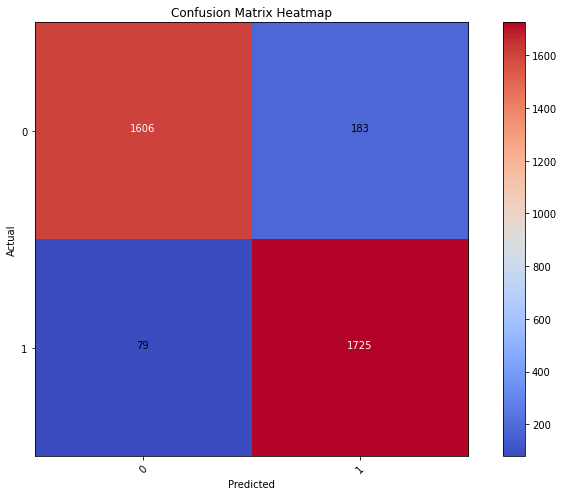

In [129]:
# Matriz de confusión
conf_matrix = confusion_matrix(ypd_test, predictions)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title('Confusion Matrix Heatmap')

tick_marks = np.arange(len(np.unique(yuas_train)))
plt.xticks(tick_marks, rotation=45)
plt.yticks(tick_marks)

thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

El primer modelo desarrollado para la detección de malware en Android consistió en el desarrollo de una red neuronal capaz de reconocer aquellas llamadas a API´s que caracterizan a una aplicación sospechosa. Originalmente se tuvo la intención de utilizar redes recurrentes, especialmente las de tipo *Long-Short Term Memory* sin embargo, al momento de trabajar con este tipo de redes la mayor precisión que se pudo obtener fue de tan solo **50%** indicando así, que el modelo no era mejor que simplemente lanzar una moneda para hacer la clasificación. Se infiere que las malas métricas obtenidas por los modelos de redes recurrentes fue debido a que estos están especialmente para trabajar ya sea con datos secuenciales (como series de tiempo) o procesamiento de lenguaje natural. Sin embargo, el conjunto de datos utilizado ya estaba en formato *one-hot-encoding* por lo que se infiere que debido a la falta de secuencialidad de los mismos es que no se pudo obtener una buena métrica.

En resultado de lo anterior, se decidió realizar un modelo "normal" de redes neuronales, únicamente compuesto por una capa de entrada, dos capas "escondidas" en este caso de tipo densas y una capa de salida, la cual se encarga de retorna el valor de la clasificación. Como se puede observar en el reporte de clasificación, el modelo obtuvo una **exactitud** de *0.93*, indicando así, que en el **93%** de los casos el modelo es capaz de clasificar correctamente una aplicación. 

Por su parte, al analizar más a detalle las métricas se puede observar, que el modelo obtuvo un **95%** de **precisión** para la clasificación de aplicaciones que no son maliciosas. Esto se puede observar en la matriz de confusión ya que de las 1685 aplicaciones clasificadas como benignas, únicamente **79** de estas (**0.046%**) fueron clasificadas incorrectamente. Esto permite garantizar que las clasificaciones benignas son en un 95% seguras. 

En constraste con lo anterior se observa la "**sensibilidad**" del modelo en cuanto a las aplicaciones clasificadas como malware, para esto se obtuvo un valor de 96%, indicando así que de las 1804 observaciones que eran malware dentro del conjunto de entrenamieto, el modelo únicamente predijo erróneamente **79** (**0.043%**) de estas.

Al observar la matriz de confusión, en el apartado de los falso positivos (aquellas aplicaciones clasificadas como malware pero que realmente eran benignas) se puede observar que es en este caso en el cual el modelo más errores cometió, correspondiendo esto, tanto a un **90%** de **precisión** para clasificar **aplicaciones de malware** y **90%** de sensibilidad para **predecir aquellas aplicaciones benignas**. 

### 2. Detección de malware basado en llamadas a API´s

In [118]:
model = models.Sequential([
    layers.Conv1D(32, 3, input_shape=(215, 1), padding='same', activation='relu'),  # capa de entrada
    layers.MaxPool1D(pool_size=2),  # sub-muestreo avg
    layers.Flatten(),  # capa entrada o aplanamiento
    layers.Dense(256, activation='relu'),  # capa escondida
    layers.Dense(1, activation='softmax')  # capa salida
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [120]:
model.fit(xuas_train, yuas_train, validation_data=(xuas_val, yuas_val), epochs=15, batch_size=64, verbose=2)

Epoch 1/15
108/108 - 2s - loss: 0.1610 - accuracy: 0.4826 - val_loss: 0.0995 - val_accuracy: 0.4679 - 2s/epoch - 23ms/step
Epoch 2/15
108/108 - 2s - loss: 0.0835 - accuracy: 0.4826 - val_loss: 0.0893 - val_accuracy: 0.4679 - 2s/epoch - 14ms/step
Epoch 3/15
108/108 - 2s - loss: 0.0669 - accuracy: 0.4826 - val_loss: 0.0933 - val_accuracy: 0.4679 - 2s/epoch - 15ms/step
Epoch 4/15
108/108 - 2s - loss: 0.0552 - accuracy: 0.4826 - val_loss: 0.0948 - val_accuracy: 0.4679 - 2s/epoch - 15ms/step
Epoch 5/15
108/108 - 2s - loss: 0.0468 - accuracy: 0.4826 - val_loss: 0.0949 - val_accuracy: 0.4679 - 2s/epoch - 14ms/step
Epoch 6/15
108/108 - 2s - loss: 0.0463 - accuracy: 0.4826 - val_loss: 0.1354 - val_accuracy: 0.4679 - 2s/epoch - 14ms/step
Epoch 7/15
108/108 - 2s - loss: 0.0369 - accuracy: 0.4826 - val_loss: 0.0876 - val_accuracy: 0.4679 - 2s/epoch - 14ms/step
Epoch 8/15
108/108 - 2s - loss: 0.0319 - accuracy: 0.4826 - val_loss: 0.1365 - val_accuracy: 0.4679 - 2s/epoch - 16ms/step
Epoch 9/15
108/1

In [ ]:
stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(xpd_train, ypd_train, batch_size=128, epochs=10, validation_split=0.15, verbose=2, callbacks=stop)

### 3. Detección de Malware basado en llamadas a API y Random Forest

In [160]:
n_estimators = 100
max_depth = None
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=19191919)
k_fold = KFold(n_splits=10, shuffle=True, random_state=19191919)
cv_scores = cross_val_score(rf_model, xuas_val, yuas_val, cv=k_fold, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.97540984 0.95901639 0.96721311 0.94262295 0.95867769 0.97520661
 0.91735537 0.96694215 0.97520661 0.97520661]
Average CV Score: 0.9612857336404282


In [161]:
# Entrena el modelo en todo el conjunto de entrenamiento
rf_model.fit(xuas_train, yuas_train)

# Realiza predicciones con el conjunto de validación
predictions = rf_model.predict(xuas_test)

accuracy = accuracy_score(yuas_test, predictions)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(yuas_test, predictions))

Accuracy: 0.9824106113033448
Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.99      0.98      1795
        True       0.99      0.98      0.98      1673

    accuracy                           0.98      3468
   macro avg       0.98      0.98      0.98      3468
weighted avg       0.98      0.98      0.98      3468



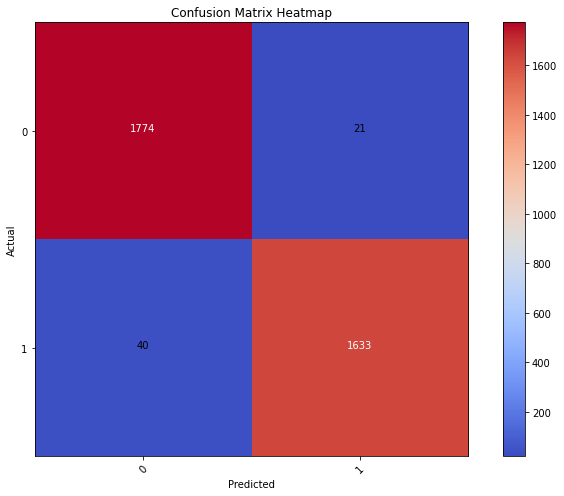

In [162]:
# Matriz de confusión
conf_matrix = confusion_matrix(yuas_test, predictions)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title('Confusion Matrix Heatmap')

tick_marks = np.arange(len(np.unique(yuas_test)))
plt.xticks(tick_marks, rotation=45)
plt.yticks(tick_marks)

thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

El modelo de Random Forest presenta un muy buen rendimiento de clasificación de Malware teniendo una presición del **98.24%** diciendonos que predice correctamente si una app es malware o no un 98.24% de las veces. Ademas vemos que las metricas de recall y f1-score tienen un puntaje de **0.98**, lo que nos dice que el modelo es bastante bueno clasificando ambas clases y en la identificacion de casos positivos reales. Además vemos en la matriz de confusión que tenemos  **21 falsos positivos** y **40 falsos negativos** de un total de **3468 predicciones**, lo que nos muestra un numero relativamente bajo de errores de clasificación a comparación de las predicciones correctass, además algo interesante es que este modelo se equivoca menos en las clasificaciones de un app como malware, y a pesar de que la presicion de esta clase es del **99%** su recall es el mismo que para la clasificación de app como no malware. Estos resultados nos dicen que el modelo tiene muy pocos errores de clasificación y tiene una alta presición y clasificando de malware, por lo que, lo puede hacer apto para la utilización en la vida real en la detección del malware.

El modelo de Random Forest para la c

El modelo de Random Forest presenta un muy buen rendimiento de clasificación de Malware teniendo una presición del **98.24%** diciendonos que predice correctamente si una app es malware o no un 98.24% de las veces. Ademas vemos que las metricas de recall y f1-score tienen un puntaje de **0.98**, lo que nos dice que el modelo es bastante bueno clasificando ambas clases y en la identificacion de casos positivos reales. Además vemos en la matriz de confusión que tenemos  **21 falsos positivos** y **40 falsos negativos** de un total de **3468 predicciones**, lo que nos muestra un numero relativamente bajo de errores de clasificación a comparación de las predicciones correctass, además algo interesante es que este modelo se equivoca menos en las clasificaciones de un app como malware, y a pesar de que la presicion de esta clase es del **99%** su recall es el mismo que para la clasificación de app como no malware. Estos resultados nos dicen que el modelo tiene muy pocos errores de clasificación y tiene una alta presición y clasificando de malware, por lo que, lo puede hacer apto para la utilización en la vida real en la detección del malware.

### 4. Detección de Malware basado en llamadas a API y Bernoulli Naive Bayes

In [146]:
naive_model = BernoulliNB()
k_fold = KFold(n_splits=10, shuffle=True, random_state=19191919)
cv_scores = cross_val_score(naive_model, xuas_val, yuas_val, cv=k_fold, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.85245902 0.76229508 0.89344262 0.86065574 0.78512397 0.8677686
 0.7768595  0.82644628 0.82644628 0.85950413]
Average CV Score: 0.8311001219346972


In [147]:
naive_model.fit(xuas_train, yuas_train)
predictions = naive_model.predict(xuas_test)

accuracy = accuracy_score(yuas_test, predictions)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(yuas_test, predictions))

Accuracy: 0.8408304498269896
Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.74      0.83      1795
        True       0.77      0.95      0.85      1673

    accuracy                           0.84      3468
   macro avg       0.86      0.84      0.84      3468
weighted avg       0.86      0.84      0.84      3468



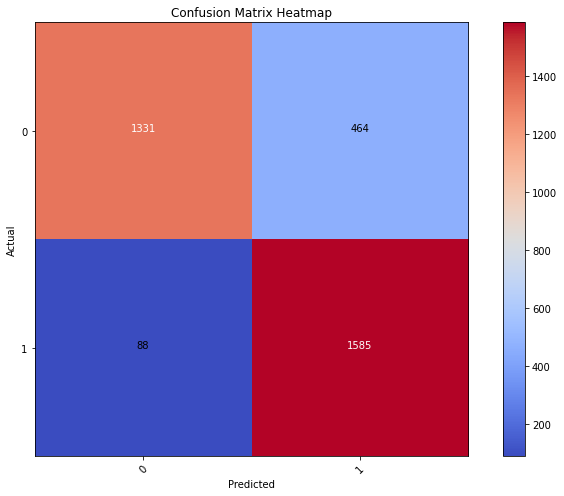

In [148]:
# Matriz de confusión
conf_matrix = confusion_matrix(yuas_test, predictions)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title('Confusion Matrix Heatmap')

tick_marks = np.arange(len(np.unique(yuas_train)))
plt.xticks(tick_marks, rotation=45)
plt.yticks(tick_marks)

thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

Como último modelo se utilizó uno hecho con *Bernoulli Naive Bayes*. Se decidió utilizar este, debido a que está diseñado para trabajar con datos binarios y como nuestros datos están en formato **one hot encoding**, el modelo es capaz de aprender las características significativas. 

Al analizar los resultados, podemos observar que el modelo obtuvo un *0.86* de precision. Este indica que el modelo tiene un 86% de probabilidad de poder clasificar correctamente una observación. Por su parte, se obtuvo un *0.84* de recall. 

## Conclusión
LO QUE MÁS NOS IMPORTA ES QUE AQUELLOS QUE DIGA QUE SON BENIGNOS EN REALIDAD SÍ SEAN BENIGNOS

## Bibliografía